In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import zipfile
import urllib.request
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image, ImageDraw
import random
import re
from scipy import spatial

# General Helper functions

In [2]:
def normalize_posenet_vector(vecteur):
    """
    This function normalize a posenet vector so that it stay exactly in a 1x1 square, without deformation.
    """
    
    x_components, y_components = zip(*vecteur)
    
    x_components, y_components = np.array(x_components), np.array(y_components)
    
    
    max_amplitude = max(max(x_components)-min(x_components),max(y_components)-min(y_components))
    
    amplification_factor = 1/max_amplitude
    
    x_components = amplification_factor*x_components
    y_components = amplification_factor*y_components
    
    def mean_extrema(array):
        return np.mean((max(array),min(array)))
    
    x_components, y_components =\
    x_components-mean_extrema(x_components) + 1/2, y_components-mean_extrema(y_components) + 1/2
    
    return list(zip(x_components, y_components))

In [3]:
def create_json_df(directory_path, json_name, normalise_function):
    
    rows = []
    
    with open(json_name, "r") as json:
        
        text = json.read()
        
        rows = []
        
        for item in eval(text):
            image_name = item.get("filename")
            
            image_id = int(re.match("\d+",image_name).group())
            
            poses = item.get("poses")
            
            normalized_poses = list(map(normalise_function, poses))
            
            if os.path.exists(directory_path+"/"+image_name):           
                rows.append({"image_identifier":image_id,\
                             "image_name": image_name, "poses":poses, "norm_poses":normalized_poses})
    
    return pd.DataFrame(rows)

In [4]:
def show_pictures(poses, name, directory_path, verbose = True):
    
    path = directory_path+"/"+name
    
    im = Image.open(path)
    
    if verbose:
        c = 0
        colors = ["red","yellow","green","blue","grey"]
        for pose in poses:

            color = colors[c]

            width, height = im.size

            draw = ImageDraw.Draw(im)

            pose = list(map(lambda tup : (width*tup[0], height*tup[1]), pose))

            for point in pose[:5]:
                x = point[0]
                y = point[1]
                r = 5
                draw.ellipse([x-r,y-r,x+r,y+r],color,color)

            for i in (5,6,11,12):
                draw.line([(pose[i][0],pose[i][1]),(pose[i+2][0],pose[i+2][1]),(pose[i+4][0],pose[i+4][1])],
                          fill = color, width = 5)

            c += 1
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.asarray(im))
    plt.show()

In [5]:
df = create_json_df("images_sample", "rijk.json", normalize_posenet_vector)

In [6]:
#df.apply(lambda row: show_pictures(row["poses"],row["image_name"], "images_sample"), axis = 1)
df.head()

,image_identifier,image_name,poses,norm_poses
0,4755,4755.jpg,"[[[0.5293581961865171, 0.22556693451877696], [...","[[(0.5151971654872998, 0.026408720898805638), ..."
1,4757,4757.jpg,"[[[0.43901160360278746, 0.25694627520639146], ...","[[(0.41651651719471994, 0.03785876021821599), ..."
2,4765,4765.jpg,"[[[0.4663637916901612, 0.2931259299994442], [0...","[[(0.49559017803830197, 0.03617211688670585), ..."
3,4769,4769.jpg,"[[[0.5060642980734039, 0.19914829035213485], [...","[[(0.5171852770174548, 0.04472297066957681), (..."
4,4773,4773.jpg,"[[[0.5160492008973683, 0.47648209078302645], [...","[[(0.3780184504853159, 0.057926999767501375), ..."


# Angular similarity

### Toolbox

#### Divergence

The divergence is the global distance score between two poses.
The min divergence is the minimum distance between a pose and any pose of a given list (representing a painting)

In [7]:
def divergence(pose1, pose2, fcompare, flist):
    """
    Give a global divergence between two poses by applying fcompare to each of functions of flist
    applied to both poses.
    The divergence is cumulative, but can be signed.
    """
    acc = 0
    
    for f in flist:
        acc += fcompare(f(pose1),f(pose2))
        
    return acc

def min_divergence(pose1, pose_list, fcompare, flist):
    
    """
    Give the minimum divergence among all poses of pose_list compared with pose1
    Useful for paintings with multiple poses, to consider only the best possible
    """
    
    current_min = np.Infinity
    
    for pose in pose_list:
        current_min = min(current_min, divergence(pose1,pose,fcompare,flist))
        
    return current_min

def painting_divergence(pose_list_1, pose_list_2, fcompare, flist):
    
    current_min = np.Infinity
    
    for pose in pose_list_1:
        current_min = min(current_min, min_divergence(pose,pose_list_2,fcompare,flist))
    
    return current_min

def painting_best_poses(pose_list_1, pose_list_2, fcompare, flist):
    """
    Return among two paintings the two most close poses of the two paintings.
    """
    current_min = np.Infinity
    current_p1 = None
    current_p2 = None
    
    for p1 in pose_list_1:
        for p2 in pose_list_2:
            if divergence(p1,p2,fcompare,flist) < current_min:
                current_min = divergence(p1,p2,fcompare,flist)
                current_p1 = p1
                current_p2 = p2
    
    return current_p1, current_p2

#### Comparison function

Those functions take two processed poses and output a distance

In [8]:
def fcompare_absolute_divergence(v1,v2):
    "Return the absolute distance between two scalars v1 and v2"
    return abs(v1-v2)

In [9]:
def fcompare_angle_signed(a1,a2):
    """
    Take two angles to horizontal between -Pi and Pi and return the signed difference of them.
    Take into account the transition between -Pi and Pi
    The first angle decide the direction of the angle, so f(a1,a2) = -f(a2,a1)
    """
    standard_difference = a1-a2
    boundary_difference = a1%(2*np.pi) - a2%(2*np.pi)
    #print("s",standard_difference)
    #print("b",boundary_difference)
    
    if np.abs(standard_difference) < np.abs(boundary_difference):
        return standard_difference
    else:
        return boundary_difference

In [10]:
def fcompare_angle_absolute(a1,a2):
    
    return np.abs(fcompare_angle_signed(a1,a2))

In [11]:
def fcompare_cosine_similarity(pose1, pose2):
    """
    Classic pose similarity.
    """
    return spatial.distance.cosine(np.array(pose1).flatten(),np.array(pose2).flatten())

#### Angle processing function

Those functions take a vector (x0,y0),(x1,y1) as input and output an angle

In [12]:
def angle_to_horizontal_old(tup1,tup2):
    """
    Return the angle to horizontal for a vector bounded by points tup1 and tup2
    Is deprecated because does not take into account the vector direction.
    In fact, it do the angle to horizontal for a raw segment
    """
    vector = np.array(tup2)-np.array(tup1)
    
    if vector[0] != 0:
        return np.arctan(vector[1]/vector[0])
    else:
        return np.arctan(vector[1]*np.Infinity)
    

In [13]:
def angle_to_horizontal(tup1,tup2):
    """
    Return the angle to horizontal, ranged between -Pi and Pi
    """
    def unit_vector(vector):
        return vector / np.linalg.norm(vector)

    v1_u = unit_vector(np.array(tup2)-np.array(tup1))
    v2_u = (1,0)
    return np.sign(v1_u[1])*np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

#### Pose processing

Those functions take a pose and parameters and output a value to be used in comparison functions

In [14]:
LEFT_HUMERUS = (5,7)
RIGHT_HUMERUS = (6,8)
LEFT_FOREARM = (7,9)
RIGHT_FOREARM = (8,10)

LEFT_THIGH = (11,13)
RIGHT_THIGH = (12,14)
LEFT_SHIN = (13,15)
RIGHT_SHIN = (14,16)

SHOULDERS = (5,6)
LEFT_SIDE = (5,11)
RIGHT_SIDE = (6,12)
PELVIS = (11,12)

In [15]:
def f_angle_segment(pose, body_part):
    """Return the angle of a body segment"""

    return angle_to_horizontal(pose[body_part[0]],pose[body_part[1]])

In [16]:
def f_angle_chunk(pose,body_part_1,body_part_2):
    """Return the angle of a large body part bounded by 2 segments"""
    mean_vector = ((np.array(pose[body_part_1[0]]) + np.array(pose[body_part_2[0]]))/2,
                   (np.array(pose[body_part_1[1]]) + np.array(pose[body_part_2[1]]))/2)
    
    return angle_to_horizontal(mean_vector[0],mean_vector[1])

#### Final distance functions

In [17]:
def distance_arm(input_pose_list,target_pose_list):
    """
    Return the smallest distance between any pose of input and any pose of target and 
    """
    
    left_list = (lambda p: f_angle_segment(p,LEFT_FOREARM), lambda p: f_angle_segment(p,LEFT_HUMERUS))
    right_list = (lambda p: f_angle_segment(p,RIGHT_FOREARM), lambda p: f_angle_segment(p,RIGHT_HUMERUS))
    
    full_list = left_list + right_list
    
    input_p, target_p = painting_best_poses(input_pose_list,target_pose_list,fcompare_angle_absolute,full_list)
        
    left_arm = divergence(input_p,target_p,fcompare_angle_signed,left_list)
    right_arm = divergence(input_p,target_p,fcompare_angle_signed,right_list)
    
    distance = np.abs(left_arm) + np.abs(right_arm)
    
    if left_arm > 0 and right_arm > 0:
        return distance, "right"
    
    elif left_arm < 0 and right_arm < 0:
        return distance, "left"
    
    elif left_arm < 0 and right_arm > 0:
        return distance, "up"
    
    else:
        return distance, "bottom"

#### Tests

In [18]:
test_df = df[(df.image_identifier == 4765) | (df.image_identifier == 4927)]

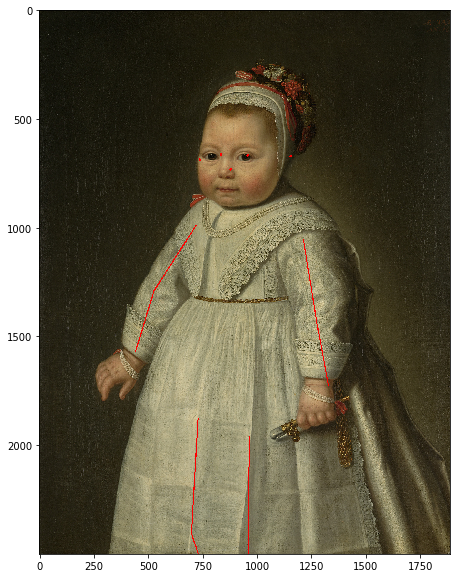

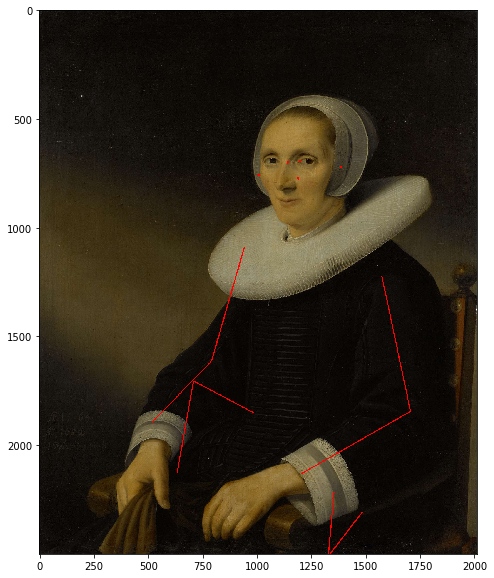

2     None
11    None
dtype: object

In [19]:
test_df.apply(lambda row: show_pictures(row["poses"],row["image_name"], "images_sample"), axis = 1)

In [20]:
pose_list_girl = df[df.image_identifier == 4765]["poses"].values[0]
pose_list_woman = df[df.image_identifier == 4927]["poses"].values[0]

print(distance_arm(pose_list_girl,pose_list_woman))
print(distance_arm(pose_list_woman,pose_list_girl))

(1.472224815921885, 'left')
(1.472224815921885, 'right')


NameError: name 'pose_girl' is not defined

### Demonstration of some functions

In [ ]:
def give_n_best_match(input_name, input_df, target_df, fcompare, flist, n=3):
    """
    Give the n best match for input image
    
    input_df and target_df must have an "image_name" and "poses" field
    """
    input_pose = input_df.loc[df["image_name"] == input_name]["norm_poses"].values[0][0]
    
    divergences = target_df["norm_poses"].apply(lambda poses: min_divergence(input_pose, poses, fcompare, flist))
    
    top_indexes = divergences.sort_values(ascending = True).index[:n]
    
    return target_df.iloc[top_indexes]

In [ ]:
df = df[df.poses.apply(lambda poses: len(poses) > 0)].reset_index()


def show_n_best_matchs(input_name,input_df,target_df,fcompare,flist,n=3):

    input_row = input_df[input_df["image_name"] == input_name]

    results = give_n_best_match(input_name,input_df,target_df,fcompare,flist,n)

    print("Input")
    input_row.apply(lambda row: show_pictures(row["poses"],row["image_name"], "images_sample"), axis = 1)
    print("Results")
    results.apply(lambda row: show_pictures(row["poses"],row["image_name"], "images_sample"), axis = 1)

In [ ]:
show_n_best_matchs("5037.jpg",df,df,fcompare_cosine_similarity,[lambda x:x],n=5)

In [ ]:
arms_list = [lambda pose : f_angle_segment(pose, LEFT_HUMERUS), lambda pose : f_angle_segment(pose, RIGHT_HUMERUS),
            lambda pose : f_angle_segment(pose, LEFT_FOREARM),lambda pose : f_angle_segment(pose, RIGHT_FOREARM)]
show_n_best_matchs("5037.jpg",df,df,fcompare_absolute_divergence,arms_list,n=5)

In [ ]:
# A faire:
# Introduire une mesure tableau de face ou de profil (ratio longueur du torse Vs largeur)
# Introduire des fonctions pour la position de la tête
# Introduire des poids pour les différentes fonctions de la liste
# Réintroduire une notion de direction dans la mesure de l'angle DONE

In [ ]:
angle_to_horizontal((0,0),(-1,-1))

In [ ]:
print(angle_to_horizontal((0,0),(1,0.5)),angle_to_horizontal((0,0),(-1,0.5)),angle_to_horizontal((0,0),(-1,-0.5)),angle_to_horizontal((0,0),(1,-0.5)))

In [ ]:
for pair in [(((0,0),(1,0.5)),((0,0),(1,1))),(((0,0),(1,1)),((0,0),(1,0.5))),
             (((0,0),(-1,0.5)),((0,0),(-1,1))),(((0,0),(-1,1)),((0,0),(-1,0.5))),
            (((0,0),(-1,-0.5)),((0,0),(-1,0.5))),(((0,0),(1,0)),((0,0),(0,-1)))]:
    
    print(\
    fcompare_angle_signed(angle_to_horizontal(pair[0][0],pair[0][1]),angle_to_horizontal(pair[1][0],pair[1][1])))

In [ ]:
(1,1) + (0,0)

In [ ]:
pd.DataFrame([{"a":2,"b":1},{"a":13,"b":3}]).loc["a"]